In [12]:
# Standard Library Imports
import os
import sys
from importlib import reload
from enum import Enum
from time import time
from pathlib import Path

# Third-Party Library Imports
import numpy as np
import xarray as xr
import dask
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import my_stats
import toe_calc
import open_data
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")
warnings.filterwarnings("ignore")

In [13]:
%config Application.verbose_crash=True

In [14]:
xr.set_options(display_expand_data=False)

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [16]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [17]:
# client.close()

In [18]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=104, threads_per_worker=1, memory_limit=None) 
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:44841
 -   dashboard at:        /proxy/40169/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:37297'
 -         Start Nanny at: 'tcp://127.0.0.1:35363'
 -         Start Nanny at: 'tcp://127.0.0.1:38563'
 -         Start Nanny at: 'tcp://127.0.0.1:41205'
 -         Start Nanny at: 'tcp://127.0.0.1:36257'
 -         Start Nanny at: 'tcp://127.0.0.1:44073'
 -         Start Nanny at: 'tcp://127.0.0.1:40261'
 -         Start Nanny at: 'tcp://127.0.0.1:46865'
 -         Start Nanny at: 'tcp://127.0.0.1:39831'
 -         Start Nanny at: 'tcp://127.0.0.1:41869'
 -         Start Nanny at: 'tcp://127.0.0.1:37669'
 -         Start Nanny at: 'tcp://127.0.0.1:45871'
 -         Start Nanny at: 'tcp://127.0.0.1:32807'
 -         Start Nanny at: 'tcp://127.0.0.1:41717'
 -         Start Nanny at: 'tcp://127.0.0.1:40171'
 -         Start Nanny at: 'tcp://127.0.0.1:46763'
 -         Start Nanny at: 'tcp://127.0.0

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40169/status,
Dashboard: /proxy/40169/status,Workers: 104
Total threads: 104,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44841,Workers: 104
Dashboard: /proxy/40169/status,Total threads: 104
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41641,Total threads: 1
Dashboard: /proxy/42517/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37297,


 - Event loop was unresponsive in Nanny for 4.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 4.81s.  This is often caused by long

In [19]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [20]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'access_ssp585_tas_(1880_1909)',
       'best_tas_(1880_1910)', 'best_tas_(1890_1920)',
       'best_tas_(1900_1930)', 'best_tas_(1910_1940)',
       'best_tas_(1920_1950)', 'best_tas_(1920_1950)_16p0x16p0',
       'best_tas_(1920_1950)_2p0x2p0', 'best_tas_(1920_1950)_32p0x32p0',
       'best_tas_(1920_1950)_4p0x4p0', 'best_tas_(1920_1950)_8p0x8p0',
       'best_tas_(1930_1960)', 'best_tas_(1940_1970)',
       'best_tas_multi_base_period.zarr',
       'cesm1_lens_rcp85_tas_(1920_1950)',
       'cesm1_lens_rcp85_tas_multi_base_period.zarr', 'era5', 'old',
       'to_delete'], dtype='<U43')

In [27]:
variable = 'tas'
# model  =  'best'

# experiment = 'rcp85'
# model = 'cesm1_lens'

experiment = 'ssp585'
model = 'access'

dataset_name = f'{model}_{experiment}'

In [28]:
SAVE_NAME = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_multi_base_period.zarr')
SAVE_NAME                         

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_multi_base_period.zarr'

In [80]:
# chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}
# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}
# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//8, 'lat':72//12}
ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': -1, 'lon':144//3}
chunks = ACCESS_CHUNKS#chunks_best_small#LE_CESM_CHUNKS

In [31]:
# If no ensemble
# plot_kwargs = {} 
# ensemble_kwargs = {}

# If ensemble
plot_kwargs = {'hue':'member', 'add_legend':False} 
ensemble_kwargs = {'member': 0}

<h2 style='color:cyan'> Opening Data </h2>

In [32]:
# data_raw_ds = open_data.open_best(chunks_best_small).persist()
# wait(data_raw_ds);

In [33]:
np.sort(os.listdir('/g/data/w40/ab2313/time_of_emergence'))

array(['.ipynb_checkpoints', '20CR_ACCESS_SSP585.nc', 'GPCC',
       'access_ssp585.zarr', 'best', 'canesm5_lens_ssp585.zarr',
       'cesm1_lens_rcp85.zarr', 'cesm1_lens_tas.zarr', 'cesm1_mask.zarr',
       'cesm1_picontrol.zarr', 'era5', 'large_ensembles', 'ssp',
       'toe_metrics', 'tp_delete'], dtype='<U24')

In [34]:
FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'
FILE_NAME

'/g/data/w40/ab2313/time_of_emergence/access_ssp585.zarr'

In [81]:
data_raw_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=chunks)['tas']
# data_raw_ds = data_raw_ds.sel(time=data_raw_ds.time.dt.year>1920)

In [82]:
data_raw_ds

<xarray.DataArray 'tas' (member: 40, time: 251, lat: 72, lon: 144)> Size: 833MB
dask.array<open_dataset-tas, shape=(40, 251, 72, 144), dtype=float64, chunksize=(1, 251, 72, 48), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (7)

In [83]:
# Tranpose time to be last dimension to make transpose easier 
data_raw_ds = data_raw_ds.transpose(..., "time").persist()
wait(data_raw_ds);

In [84]:
data_raw_ds.chunks

((1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1),
 (72,),
 (48, 48, 48),
 (251,))

In [85]:
# data_raw_ds = data_raw_ds.isel(member=slice(0,3))

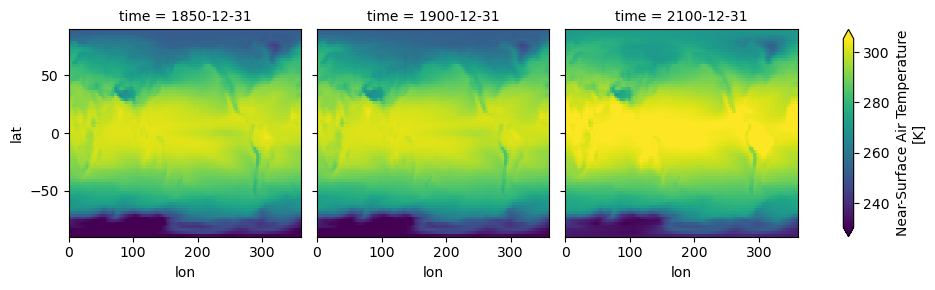

In [86]:
data_raw_ds.isel(time=[0, 50, -1]).isel(**ensemble_kwargs).plot(col='time', robust=True)

In [42]:
data_raw_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 251)> Size: 833MB
dask.array<transpose, shape=(40, 72, 144, 251), dtype=float64, chunksize=(1, 6, 12, 251), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (7)

<h1 style='color:yellow'>  Calculations</h1>

In [43]:
# def fga(data_ds, base_period_ds, data_ds_window):
#     # The x-values for the KDE are based upon the max and min
#     data_max = data_ds.max().persist().values.item()
#     data_min = data_ds.min().persist().values.item()
#     num_points = 1000
#     x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)
    
    
#     kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)
    
#     base_period_kde = xr.apply_ufunc(
#         toe_calc.create_kde_x_exists,
#         base_period_ds,
#         input_core_dims=[['time'], ],
#         output_core_dims=[['x']],
#         kwargs={'x': x, **kde_kwargs},
#         vectorize=True,
#         dask='parallelized',
#         output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
#         output_dtypes=float
#     ).persist()
#     wait(base_period_kde);
    
#     frac_geom_ds = xr.apply_ufunc(
#         toe_calc.fractional_geometric_area_optimized,
#         data_ds_window,
#         base_period_kde,
#         input_core_dims=[['window_dim'], ['x']],
#         exclude_dims={'window_dim'},
#         kwargs={'x': x, 'method_kwargs':kde_kwargs},
#         vectorize=True,
#         dask='parallelized',
#         output_dtypes=float
#     ).compute()
#     # wait(frac_geom_ds2)
    
#     x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
#     frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}

#     frac_geom_ds.name = 'frac'
    
#     return frac_geom_ds

In [44]:
# def ks(data_ds_window, base_period_window_ds):
#     # The arguements needed for all of the calculations
#     rolling_window_kwargs = dict(
#         input_core_dims=[['window_dim'], ['window_dim']],
#         exclude_dims={'window_dim'},
#         vectorize=True,
#         dask='parallelized')
    
#     ks_ds = xr.apply_ufunc(
#             toe_calc.return_ks_pvalue,
#             data_ds_window,
#             base_period_window_ds,
#         **rolling_window_kwargs
#         ).compute()

#     ks_ds.name = 'ks'
#     return ks_ds

In [45]:
# def sn_ratio(data_ds, base_period_ds, base_period):

#     # Resetting the anomlies to 1850
#     data_anom_ds = data_ds - base_period_ds.mean(dim='time')
#     base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')
    
#     ds_signal_lowess = xr.apply_ufunc(
#         my_stats.apply_lowess, 
#         data_anom_ds.chunk({'time':-1, 'lat':10}), 
#         input_core_dims=[['time']],
#         output_core_dims=[['time']],
#         vectorize=True, 
#         kwargs = dict(window=41),
#         dask='parallelized',
#         output_dtypes=[float]
#     ).compute()
    
#     # Noise series is detrended data
#     ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
    
#     ds_noise_lowess_base_period = ds_noise_series_lowess.sel(
#         time=slice(str(base_period.start), str(base_period.end))).std(dim='time')
        
#     # S/N 
#     ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period
#     ds_sn_lowess_base_period.name = 'sn'

#     return ds_sn_lowess_base_period

In [46]:
from toe_calc_variations import fga, ks, sn_ratio

In [87]:
window = 30
CHUNKS_FOR_PVALUE_TESTS = chunks

In [88]:
# raw_data_ds = raw_data_ds.sel(lat=slice(0, 10), lon=slice(110, 120))

In [89]:
data_raw_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 251)> Size: 833MB
dask.array<transpose, shape=(40, 72, 144, 251), dtype=float64, chunksize=(1, 72, 48, 251), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (7)

In [50]:
SAVE_NAME

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_tas_multi_base_period.zarr'

In [51]:
# Check if file already exists
# If it does, check what base_period is has already been saved with
if Path(SAVE_NAME).exists():
    print('File already exists')
    with xr.open_zarr(SAVE_NAME) as ds:
        save_based_periods = np.array(ds.base_period.values)
else:
    print('File does not exist yet')
    save_based_periods = []#['-9999'] # Default fill to stop erros

File does not exist yet


In [52]:
save_based_periods_start = list(map(lambda x: int(x.split('_')[0]), save_based_periods))
save_based_periods_start

[]

In [53]:
base_period_starts = np.sort(list(map(lambda x: int(x.split('_')[0]), save_based_periods)))
base_period_starts

array([], dtype=float64)

In [54]:
# all_base_periods = np.arange(1920, 2055, 5)
all_base_periods = np.arange(1850, 2050, 5)
all_base_periods

array([1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900,
       1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955,
       1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010,
       2015, 2020, 2025, 2030, 2035, 2040, 2045])

In [55]:
base_periods_to_run = np.array([bp for bp in all_base_periods if bp not in save_based_periods_start])
base_periods_to_run

array([1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900,
       1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955,
       1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010,
       2015, 2020, 2025, 2030, 2035, 2040, 2045])

In [56]:
# base_periods_to_run = all_base_periods[all_base_periods>largest_base_period]
# base_periods_to_run

In [57]:
base_periods_to_run.shape

(40,)

In [58]:
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="ks_2samp: Exact calculation unsuccessful")

In [62]:
data_raw_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 251)> Size: 833MB
dask.array<transpose, shape=(40, 72, 144, 251), dtype=float64, chunksize=(1, 6, 12, 251), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (7)

In [97]:
for i, base_period_start in enumerate(base_periods_to_run):
    t_start = time()
    print(f'{base_period_start}, ', end='')
    
    data_ds = data_raw_ds.copy()
    data_ds = data_ds.sel(time=data_ds.time.dt.year>base_period_start)
    
    base_period_obj = toe_const.BasePeriod(base_period_start, base_period_start+29)
    
    base_period_ds = data_ds.sel(
        time=slice(str(base_period_obj.start), str(base_period_obj.end)))

    
    base_period_ds_count = base_period_ds.count(dim='time')
    percent_80_of_years = 0.8*(base_period_obj.end - base_period_obj.start)

    data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
    
    data_ds = data_ds.where(data_availability_mask)
    base_period_ds = base_period_ds.where(data_availability_mask)
    
    data_ds_window = (
        data_ds
        .rolling(time=window, center=True, min_periods=window)
        .construct('window_dim')
        .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
        .persist()
    ) 
    
    base_period_window_ds = (
        data_ds.sel(time=slice(str(base_period_obj.start), str(base_period_obj.end)))
        .chunk(CHUNKS_FOR_PVALUE_TESTS)
        .rename({'time':'window_dim'})
        .persist()
    )

    wait(data_ds_window);
    wait(base_period_window_ds);
    
    sn_ds = sn_ratio(data_ds, start=base_period_obj.start, end=base_period_obj.end)
    # sn_ratio(data_ds, base_period_ds, base_period_obj)
    print('.', end='')
    ks_ds = ks(data_ds_window, base_period_window_ds)
    print('.', end='')
    fga_ds = fga(data_ds, base_period_ds, data_ds_window)
    print('.', end='')

    out_ds = xr.merge([sn_ds, ks_ds, fga_ds])
    out_ds = out_ds.expand_dims('base_period').assign_coords(
        base_period=[f'{base_period_obj.start}_{base_period_obj.end}'])
    # Length of time needs to match - pad with nans
    out_ds = out_ds.reindex(time=data_raw_ds.time, fill_value=np.nan)

    if not Path(SAVE_NAME).exists():
        print(' - creaing new file - ', end='')
        out_ds.to_zarr(SAVE_NAME, mode='w')
    else:
        print(f' - appending {base_period_obj.start}_{base_period_obj.end} to baese_period dim - ', end='')
        out_ds.to_zarr(SAVE_NAME, mode='a', append_dim='base_period')
        
    time_taken = (time() - t_start)/60
    print(f' ({time_taken:.2f})')

1850, .

2025-03-12 15:12:26,324 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('vectorize_return_statistical_pvalue-vectorize_return_statistical_pvalue_0-transpose-93e175ad133fd89ef8bdb8eafb57673-6177', 29, 0, 1, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2025-03-12 15:12:26,324 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('vectorize_return_statistical_pvalue-vectorize_return_statistical_pvalue_0-transpose-93e175ad133fd89ef8bdb8eafb57673-6177', 3, 0, 0, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2025-03-12 15:12:26,325 - distributed.worker.state_machine - WARNING - Async instructio

In [95]:
# out_ds_2 = out_ds.copy(deep=True)

In [96]:
# Pad new out_ds to match max_time_len
# out_ds_2 = out_ds_2.reindex(time=data_raw_ds.time, fill_value=np.nan)

In [104]:
# Now append safely
# out_ds_2.to_zarr(SAVE_NAME, mode='a', append_dim='base_period')

In [50]:
# base_period_ds = xr.concat(base_period_stor, dim='base_period')

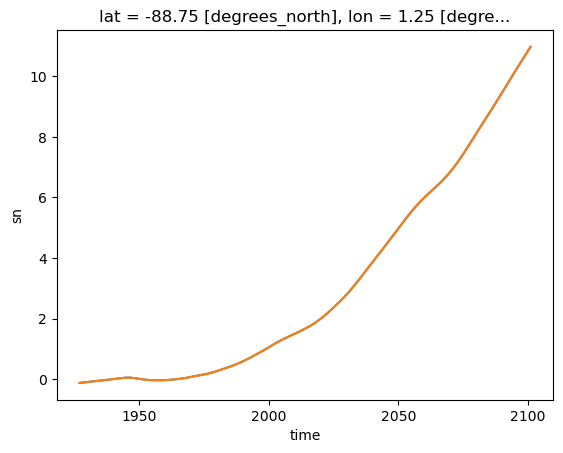

In [103]:
out_ds.sn.isel(member=0, lat=0, lon=0).plot(hue='base_period', add_legend=False);
out_ds_2.sn.isel(member=0, lat=0, lon=0).plot(hue='base_period', add_legend=False);

In [ ]:
# base_period_ds.to_zarr(SAVE_NAME, mode='w')